Datetime
2020-10-06 22:00:00    105.655
2020-10-06 22:10:00    105.665
2020-10-06 22:20:00    105.681
2020-10-06 22:30:00    105.654
2020-10-06 22:40:00    105.654
Name: Close, dtype: object
[down/up]
[1721, 1829, 6]
accuracy_score: 0.5286931818181818
precision_score: [0.41710603 0.63375621]
13


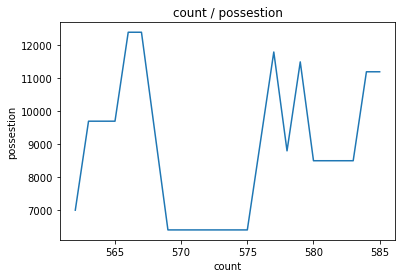

[0. 1. 0. ... 0. 1. 0.]


In [15]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib as plt
from IPython.display import display
import talib as ta

import time
import math


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")

# year_months =[ [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2016, 5], [2016, 6], [2016, 7], [2016, 8], [2016, 9], [2016, 10], [2016, 11], [2016, 12],
#     [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2017, 5], [2017, 6], [2017, 7], [2017, 8], [2017, 9], [2017, 10], [2017, 11], [2017, 12],
#     [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2018, 5], [2018, 6], [2018, 7], [2018, 8], [2018, 9], [2018, 10], [2018, 11], [2018, 12],[2019, 1], [2019, 2], [2019, 3], [2019, 4], [2019, 5], [2019, 6], [2019, 7]]

## Oandaからcandleデータを取得する。 時差のため、現在のレート取得のため、-9h
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    #adjust = datetime.timedelta(hours=-4)
    adjust = datetime.timedelta(hours=9) #GMT to JPN
    
    data = []
    for res in JSONRes['candles']:
        temp = [datetime.datetime.fromisoformat(res['time'][:19]) + adjust] #indexとなる時間を追加
        
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
        
#         month = datetime.datetime.fromisoformat(res['time'][:19]).month
        
#         for i in range(1,13):
           
#             if(month==i):
#                 temp.extend([1]) #月をonehotで追加
#                 #time.sleep(0.1)
#             else:
#                 temp.extend([0])
                
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
#         weekday = datetime.datetime.fromisoformat(res['time'][:19]).weekday
        
#         for i in range(0,7):
            
#             if(weekday==i):
#                 temp.extend([1]) #曜日をonehotで追加
#                 #time.sleep(0.00001)
#             else:
#                 temp.extend([0])
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data


def get_test_data(testtime, period=50000):
    all_data = []

    NY = datetime.timedelta(hours=-13) + datetime.timedelta(seconds=-1)#レートは時差を考慮して取得

    # -13hしないと"This time is future"となることから、入力した時間はNY時間として認識される。

    bias = datetime.timedelta(days=0)

#     date_from = datetime.datetime.now() + NY + datetime.timedelta(minutes=-50000) + bias
#     date_to =  datetime.datetime.now() + NY +bias
    
    date_from = testtime + NY + datetime.timedelta(minutes=-period) + bias
    date_to =  testtime + NY + bias
    

    #print("入力はNY(-13h)で行う。これにより最新のレートが取得できる。")
    #print("JPN: "+str(datetime.datetime.now()))
    #print("NY: "+str(date_from)+" "+str(date_to))
    #print("GMT(index): "+str(date_from+datetime.timedelta(hours=4))+" "+str(date_to+datetime.timedelta(hours=4)))

    ret = getCandleDataFromOanda("USD_JPY", api, date_from, date_to, "M10")
    twohours_data = oandaJsonToPythonList(ret)#取得したデータを格納



    all_data.extend(twohours_data)#データを追加

    #print(all_data)

    #ここからall_dataに追加すればよい


    # pandas DataFrameへ変換
    now_df = pd.DataFrame(all_data)
    now_df.columns = ['Datetime',"hour_range",
                  #"January","February","March","April","May","June","July","August","September","October","November","December",
                  "day",
                  #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
                  'Volume', 'Open', 'High', 'Low', 'Close']
    now_df = now_df.set_index('Datetime')

    return now_df
#print(now_df)

def adjust_now_data(df):
    
    df = df.astype(float)
    
    #以降全ての計算でレート終値を使う
    close = np.array(df["Close"])
    
    
    #特徴量を入れるための空のdataframeを作成
    df_feature = pd.DataFrame(columns=[ 
        "Close",
        "hour_range",
        #"January","February","March","April","May","June",
        #"July","August","September","October","November","December",
        "day",
        #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
        "SMA_hour/current",
        "SMA_2hour/current",
        "RSI",
        "MACD",
        "BBANDS+2σ",
        "BBANDS-2σ",
        ])

    df_feature["Close"] = df["Close"]
    df_feature["hour_range"] = df["hour_range"]
    
#     df_feature["January"] = df["January"]
#     df_feature["February"] = df["February"]
#     df_feature["March"] = df["March"]
#     df_feature["April"] = df["April"]
#     df_feature["May"] = df["May"]
#     df_feature["June"] = df["June"]
#     df_feature["July"] = df["July"]
#     df_feature["August"] = df["August"]
#     df_feature["September"] = df["September"]
#     df_feature["October"] = df["October"]
#     df_feature["November"] = df["November"]
#     df_feature["December"] = df["December"]
    
    #print(df_feature.isnull().any())
    
    #print(df_feature.isnull().any())
    
#     days=["Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday"]
#     for i in days:
#         df_feature[i] = df[i]

#     df_feature["Sunday"] = df["Sunday"]
#     df_feature["Monday"] = df["Monday"]
#     df_feature["Thuesday"] = df["Thuesday"]
#     df_feature["Wednesday"] = df["Wednesday"]
#     df_feature["Thursday"] = df["Thursday"]
#     df_feature["Friday"] = df["Friday"]
#     df_feature["Saturday"] = df["Saturday"]
    
    
    
    df_feature["day"] = df["day"]

    
    
    
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる

    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA_hour/current"]= ta.SMA(close, timeperiod=6) / close
    df_feature["SMA_2hour/current"]= ta.SMA(close, timeperiod=12) / close

    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)

    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)

    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close
    df_feature["BBANDS-2σ"] = lower / close

    
    c=[0,0,0]
    
    
    def classify(x):

        if x<0:
            c[0]+=1
            return 0
        elif 0<=x:
            c[1]+=1
            return 1
        else:
            c[2] +=1

    legs = 60
    
    classified = pd.DataFrame(columns=["class"])
    classified["class"] = (df["Close"].pct_change(int(legs/10))*100).apply(lambda x: classify(x))

    #classified = classified.shift(-1)
    classified = classified.shift(-int(legs/10))
    
    
    #df_adjusted=df_feature[30:len(df_feature)-2]
    #classified=classified[30:len(classified)-2]
    df_adjusted=df_feature[30:len(df_feature)-int(legs/10)]
    classified=classified[30:len(classified)-int(legs/10)]
    
    
    print("[down/up]")
    print(c)
    
    
    #print(df_adjusted, classified)
    
    return df_adjusted, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def test_predict(testtime, filename = 'RF_01.sav'):
    
    data_num = 50000
    
    now_df = get_test_data(testtime, data_num)
    
    print(now_df["Close"].tail())
    
    X_now, y_now = adjust_now_data(now_df)

    #print(X_now, y_now)

    loaded_model = pickle.load(open(filename, 'rb'))
    
    result = loaded_model.predict(X_now)

    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(loaded_model.predict(X_now)[:data_num-6], y_now["class"].values[:data_num-6]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(loaded_model.predict(X_now)[:data_num-6], y_now["class"].values[:data_num-6], average=None))
    
    possestion = 10000
    pay = 1000*3
    
    po_rate = 1.9
    
    c_array = []
    p_array = []
    
    j = 0
    k = 0
    
    #for i in range(550,int(result.size/6)):
    for i in range(int(result.size/6)-24,int(result.size/6)):
        
        if(result[i] == 0):# down予想なら買わない
            c_array.extend([i])
            p_array.extend([possestion])
            j += 6
            k += 1
            continue
        
        possestion -= pay
        
        if result[j] == y_now["class"].values[j]:
            possestion += pay*po_rate
        elif result[j] != y_now["class"].values[j]:
            pass
        else:
            print(error)
        
        c_array.extend([i])
        p_array.extend([possestion])
        
        j += 6
        
    print(k)
    import matplotlib.pyplot as plt
    
    # グラフを書く
    plt.plot(c_array, p_array)

    # グラフのタイトル
    plt.title("count / possestion")

    # x軸のラベル
    plt.xlabel("count")

    # y軸のラベル
    plt.ylabel("possestion")

    # 表示する
    plt.show()
#     from sklearn.metrics import confusion_matrix
#     print(confusion_matrix(y_now["class"].values[:data_num-6], loaded_model.predict(X_now)[:data_num-6]))
    
    return result



print(test_predict(datetime.datetime.now()+datetime.timedelta(days=0)))



